In [1]:
import os
import glob
import json
import torch
import argparse
import utils_plot
import numpy as np
from torch import nn
from tqdm import tqdm
from pathlib import Path
from models import UNet11
from loss import dice_coef
import torch.backends.cudnn
import torch.optim as optim
from torch.optim import Adam
import albumentations as albu
import matplotlib.pyplot as plt
from dataset import WaterDataset
from scalarmeanstd import meanstd
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler 
from torch.utils.data import DataLoader
from metrics_prediction import calc_loss
from split_train_val import get_files_names
from torchvision import transforms, datasets, models
from get_train_test_kfold import get_split_out, percent_split, get_split_in

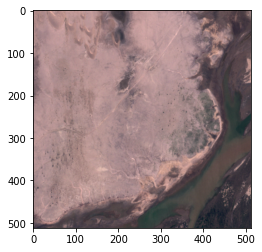

In [2]:
img = np.load(os.path.join('data/','train_val_850_2/images/rgbnir24608-3072.npy'))[:3]
img = (img - img.min()) / (img.max() - img.min())
plt.imshow(img.transpose(1,2,0))

## Definitions

In [3]:
num_classes = 1
input_channels = 4
batch_size = 4
lr = 0.005

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)


cuda:1


In [5]:
#Definition of teacher model
model_teach = UNet11()

if torch.cuda.is_available():
    model_teach = nn.DataParallel(model_teach, device_ids=[1])

In [6]:
data_path = Path("data/")


#Labeled images
train_val_file_names = np.array(sorted(glob.glob(str((data_path/'train_val_850_2'/'images'))+ "/*.npy")))
test_file_names = np.array(sorted(glob.glob(str((data_path/'test_850_2'/'images')) + "/*.npy")))

train_file_lab,val_file_lab = get_split_in(train_val_file_names,0)

max_values, mean_values, std_values=meanstd(train_file_lab, val_file_lab,test_file_names,str(data_path),input_channels)

print(mean_values, std_values, max_values)

elapsed time: 6.368684262037277
Train: data 751 min  0 max  3521
mean:[0.11289885 0.10246669 0.11346575 0.1396483 ]
std:[0.08914584 0.0666959  0.05693271 0.11042776]
Val: data 188 min  0 max  3440
mean:[0.11717311 0.10560063 0.1165011  0.13805926]
std:[0.09240376 0.06936888 0.05979758 0.11221593]
Test: data 182 -min  0 max  3272
mean:[0.10808238 0.09674959 0.10814647 0.13168366]
std:[0.08546968 0.06265724 0.05298235 0.10878518]
All: data 945 min  0 max  3521
mean:[0.11383374 0.10310764 0.11405758 0.13963067]
std:[0.08972336 0.06713878 0.05742005 0.11076992]
[0.11289885 0.10246669 0.11346575 0.1396483 ] [0.08914584 0.0666959  0.05693271 0.11042776] 3521


In [7]:
def make_loader(file_names, shuffle=False, transform=None, limit=None,  mode = "train",batch_size=4,limite=None) :
    return DataLoader(
        dataset=WaterDataset(file_names, transform=transform, mode = mode,limit=limit),
        shuffle=shuffle,
        batch_size= batch_size,
        pin_memory=False
    )

## Transformations

In [8]:
train_transforms = albu.Compose([
    albu.Normalize(mean=mean_values, std=std_values, max_pixel_value=max_values)
])

val_transforms = albu.Compose([
    albu.CenterCrop(height=512,width=512),
    albu.Normalize(mean=mean_values, std=std_values, max_pixel_value=max_values)
])

In [9]:
train_loader_lab = make_loader(train_file_lab, shuffle=True, transform=train_transforms , batch_size = batch_size , mode = "train")
valid_loader_lab = make_loader(val_file_lab, transform=val_transforms, batch_size = batch_size, mode = "train")

In [10]:
dataloaders_lab= {
    'train': train_loader_lab, 'val': valid_loader_lab
}

In [11]:
dataloaders_sizes = {
    x: len(dataloaders_lab[x]) for x in dataloaders_lab.keys()

}
print('Dataloaders sizes: ',dataloaders_sizes)

Dataloaders sizes:  {'train': 188, 'val': 47}


## Printing some images and labels

Training images (only RGB)


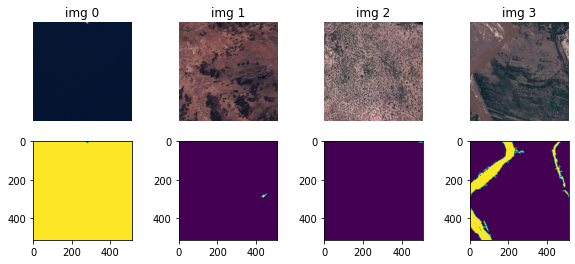

In [12]:
print('Training images (only RGB)')
images, labels = next(iter(train_loader_lab))

fig, axes = plt.subplots(figsize=(10,4), ncols=4, nrows=2)
for ii in range(4):
    ax = axes[0][ii]
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    ax = axes[1][ii]
    ax.imshow(labels[ii].squeeze().numpy())

Validation images (only RGB)


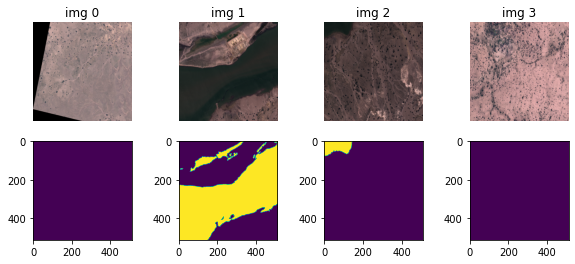

In [13]:
print('Validation images (only RGB)')
images, labels = next(iter(valid_loader_lab))

fig, axes = plt.subplots(figsize=(10,4), ncols=4, nrows=2)
for ii in range(4):
    ax = axes[0][ii]
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    ax = axes[1][ii]
    label = labels[ii].squeeze().numpy()
    ax.imshow(label)

In [14]:
optimizer_ft = optim.Adam(list(model_teach.parameters()), lr=lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) 

## Training the Teacher Model

In [15]:
#Some important parameters
out_file = "sftr"
name_file = "sftr"
name_model = "UNet11"
fold_out = 0
fold_in = 0
num_epochs = 30
scheduler = exp_lr_scheduler
optimizer = optimizer_ft
n_steps=15

In [16]:
#Initializing model weights, loss and output file
import copy
import time
from collections import defaultdict
best_model_teach_wts = copy.deepcopy(model_teach.state_dict())
best_loss = 1e18
f = open("history_{}/history_model{}_{}_foldout{}_foldin{}_{}epochs.txt".format(out_file,name_file,name_model,fold_out,fold_in,num_epochs), "w+")  

In [17]:
phase_loss_list = {
    'train':[], 'val':[]
}

phase_dice_list = {
    'train':[], 'val':[]
}

for epoch in range(num_epochs):
    print('------------------------ EPOCH {} ------------------------'.format(epoch))
    since = time.time()
    epoch_dice = 0
    
    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])

            model_teach.train()  # Set model to training mode
        else:
            model_teach.eval()   # Set model to evaluation mode

        metrics = defaultdict(float)
        epoch_samples_l2 = epoch_samples_l3 = epoch_samples_loss = 0


        for i in range(n_steps): 
            input_lab, labels_lab= next(iter(dataloaders_lab[phase]))    

            input_lab = input_lab.to(device)
            labels_lab = labels_lab.to(device)               
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                pred_lab = model_teach(input_lab)
                loss = calc_loss(pred_lab, labels_lab, metrics)
                dice = dice_coef(torch.sigmoid(pred_lab).cpu(), labels_lab.cpu()).item()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            epoch_dice += dice * input_lab.size(0)
            epoch_samples_loss += input_lab.size(0)
            epoch_samples_l2 += input_lab.size(0) 

        epoch_loss = metrics['loss'] / epoch_samples_loss
        epoch_dice = epoch_dice / epoch_samples_loss
        
        print('{} loss {:.3f} | Dice {:.4f}'.format(phase, epoch_loss, epoch_dice))
        phase_loss_list[phase].append(epoch_loss)
        print("Dice entering: {}".format(epoch_dice))
        phase_dice_list[phase].append(epoch_dice)
        
        if phase == 'val' and epoch_loss < best_loss:
            print("Saving best model...")
            best_loss = epoch_loss
            torch.save(model_teach.state_dict(), "models/model_teach.pth")
            best_model_teach_wts = copy.deepcopy(model_teach.state_dict())


    time_elapsed = time.time() - since
print('Best val loss: {:4f}'.format(best_loss))
f.write('Best val loss: {:4f}'.format(best_loss)  + "\n")
f.close()

------------------------ EPOCH 0 ------------------------
LR 0.005


/home/agallardo/ternaus/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train loss 335.234 | Dice 0.2846
Dice entering: 0.2846394992637215
val loss 0.593 | Dice 0.1930
Dice entering: 0.19303724006938866
Saving best model...
------------------------ EPOCH 1 ------------------------
LR 0.005
train loss 4.813 | Dice 0.3154
Dice entering: 0.3154159625371297
val loss 0.418 | Dice 0.3245
Dice entering: 0.3244850752088759
Saving best model...
------------------------ EPOCH 2 ------------------------
LR 0.005
train loss 0.347 | Dice 0.5109
Dice entering: 0.510941888888677
val loss 0.350 | Dice 0.4527
Dice entering: 0.45266584797037973
Saving best model...
------------------------ EPOCH 3 ------------------------
LR 0.005
train loss 0.296 | Dice 0.6011
Dice entering: 0.6011455655097961
val loss 0.287 | Dice 0.4862
Dice entering: 0.48619037767251333
Saving best model...
------------------------ EPOCH 4 ------------------------
LR 0.005
train loss 0.271 | Dice 0.5716
Dice entering: 0.5715729892253876
val loss 0.280 | Dice 0.5015
Dice entering: 0.5014759535590808
Savi

In [18]:
model_teach.load_state_dict(best_model_teach_wts)

<All keys matched successfully>

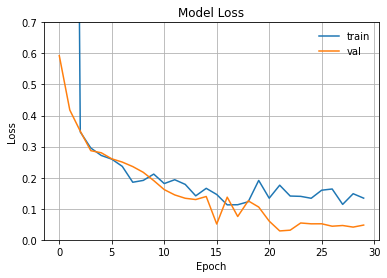

In [19]:
plt.plot(phase_loss_list['train'],label='train')
plt.plot(phase_loss_list['val'], label='val')
plt.legend(frameon=False)
plt.ylim(0, 0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title("Model Loss")
plt.show()

In [20]:
print(phase_dice_list['train'])

[0.2846394992637215, 0.3154159625371297, 0.510941888888677, 0.6011455655097961, 0.5715729892253876, 0.5661566145718098, 0.6150230586528778, 0.7057770450909933, 0.6737996240456899, 0.6612237287064393, 0.6986343026161194, 0.6582281132539113, 0.7216718037923177, 0.7877613226572673, 0.7471772213776906, 0.7444116612275441, 0.8378513177235921, 0.8093965530395508, 0.77575856645902, 0.6933947722117106, 0.8143937071164449, 0.7144546965758006, 0.7641662796338399, 0.7825819114844005, 0.7842491507530213, 0.7354202429453532, 0.7207055807113647, 0.805668846766154, 0.7461190740267436, 0.7812849501768748]


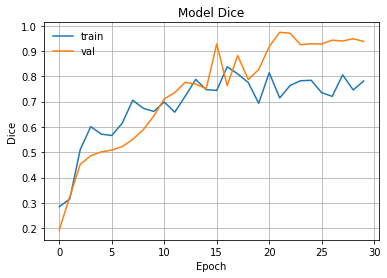

In [21]:
plt.plot(phase_dice_list['train'],label='train')
plt.plot(phase_dice_list['val'], label='val')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.grid()
plt.title("Model Dice")
plt.show()

# Generating labels for unlabeled dataset

In [43]:
#Unlabeled images

train_val_file_names_unlab = np.array(sorted(glob.glob(str((data_path/'unlabel'/'sftr'/'images'))+ "/*.npy")))

In [45]:
#Train and validation loaders
train_val_loader_unlab = make_loader(train_val_file_names_unlab, shuffle=True, transform=train_transforms, batch_size = batch_size//2, mode = "unlb_train")

In [46]:
print('Generating masks from loaders...')
train_val_pseudo = []
ratio_threshold = 0.1

for images, labels in iter(train_val_loader_unlab):
    for ii in range(len(images)):
        label = model_teach(images[ii].unsqueeze(0))
        label = torch.sigmoid(label.squeeze()).cpu().detach().numpy()
        mask = label[:,:] >= 0.9

        total_water = mask.sum()
        total_pix = mask.size

        if total_water / total_pix >= ratio_threshold:
            img_name = labels[ii]
            train_val_pseudo.append(img_name)
            pos = img_name.find("images")
            mask_name = img_name[:pos] + 'masks/' + img_name[pos+7:-4] + "_a.npy"
            mask = np.expand_dims(mask, axis=0)
            np.save(mask_name, mask)
print("Masks generated!")

Generating masks from loaders...
Masks generated!


In [47]:
print(len(train_val_pseudo))

36


## Preparing dataset for student model

In [49]:
train_file_pseudo,val_file_pseudo = get_split_in(np.array(train_val_pseudo),0)

In [51]:
#Train and validation loaders
train_loader_pseudo = make_loader(np.array(list(train_file_lab) + list(train_file_pseudo)), shuffle=True, transform=train_transforms, batch_size = batch_size//2, mode = "train")
valid_loader_pseudo = make_loader(np.array(list(val_file_lab) + list(val_file_pseudo)), transform=val_transforms, batch_size = batch_size//2, mode = "train")

In [52]:
dataloaders_pseudo= {
    'train': train_loader_pseudo, 'val': valid_loader_pseudo
}

In [53]:
dataloaders_sizes = {
    x: len(dataloaders_pseudo[x]) for x in dataloaders_pseudo.keys()

}
print('Dataloaders sizes: ',dataloaders_sizes)

Dataloaders sizes:  {'train': 390, 'val': 98}


Images with pseudolabels (only RGB)


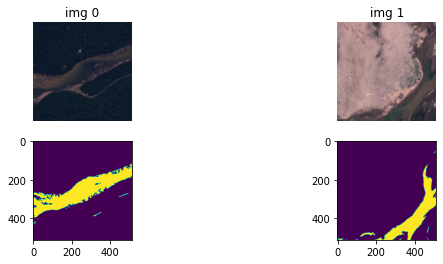

In [92]:
print('Images with pseudolabels (only RGB)')
images, labels = next(iter(train_loader_pseudo))

fig, axes = plt.subplots(figsize=(10,4), ncols=2, nrows=2)
for ii in range(2):
    ax = axes[0][ii]
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="img {}".format(ii))
    
    ax = axes[1][ii]
    label = labels[ii].squeeze().numpy()
    ax.imshow(label)

## Training student model

In [76]:
#Definition of the student model
model_stud = UNet11(num_classes=num_classes, input_channels=input_channels)

if torch.cuda.is_available():
    model_stud = nn.DataParallel(model_stud, device_ids=[1])
    
#model_stud.load_state_dict(torch.load("models/model_30epoch_UNet11_fold0.pth"))

In [77]:
optimizer_ft = optim.Adam(list(model_stud.parameters()), lr=lr)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1) 

In [78]:
#Some important parameters
out_file = "sftr"
name_file = "sftr"
name_model = "UNet11"
fold_out = 0
fold_in = 0
num_epochs = 30
scheduler = exp_lr_scheduler
optimizer = optimizer_ft
n_steps=15

In [79]:
best_model_stud_wts = copy.deepcopy(model_stud.state_dict())
best_loss = 1e18
f = open("history_{}/history_model{}_{}_foldout{}_foldin{}_{}epochs.txt".format(out_file,name_file,name_model,fold_out,fold_in,num_epochs), "w+")  

In [80]:
phase_loss_list = {
    'train':[], 'val':[]
}

phase_dice_list = {
    'train':[], 'val':[]
}

for epoch in range(num_epochs):
    print('------------------------ EPOCH {} ------------------------'.format(epoch))
    since = time.time()

    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step()
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])

            model_stud.train()  # Set model to training mode
        else:
            model_stud.eval()   # Set model to evaluation mode

        metrics = defaultdict(float)
        epoch_samples_l2 = epoch_samples_l3 = epoch_samples_loss = 0


        for i in range(n_steps): 
            input_pseudo, labels_pseudo= next(iter(dataloaders_pseudo[phase]))    

            input_pseudo = input_pseudo.to(device)
            labels_pseudo = labels_pseudo.to(device)               
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                pred_pseudo = model_stud(input_pseudo)
                loss = calc_loss(pred_pseudo, labels_pseudo, metrics)
                dice = dice_coef(torch.sigmoid(pred_pseudo).cpu(), labels_pseudo.cpu()).item()
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_dice += dice * input_lab.size(0)
            epoch_samples_loss += input_lab.size(0)
            epoch_samples_l2 += input_lab.size(0) 

        epoch_loss = metrics['loss'] / epoch_samples_loss
        epoch_dice = epoch_dice / epoch_samples_loss
        
        print('{} loss {:.3f} | Dice {:.4f}'.format(phase, epoch_loss, epoch_dice))
        phase_loss_list[phase].append(epoch_loss)
        print("Dice entering: {}".format(epoch_dice))
        phase_dice_list[phase].append(epoch_dice)
        if phase == 'val' and epoch_loss < best_loss:
            print("Saving best model...")
            best_loss = epoch_loss
            best_model_stud_wts = copy.deepcopy(model_stud.state_dict())


    time_elapsed = time.time() - since

print('Best val loss: {:4f}'.format(best_loss))
f.write('Best val loss: {:4f}'.format(best_loss)  + "\n")
f.close()

------------------------ EPOCH 0 ------------------------
LR 0.005
train loss 25729.245 | Dice 0.5457
Dice entering: 0.5456663680291001
val loss 0.224 | Dice 0.3307
Dice entering: 0.3306769356333809
Saving best model...
------------------------ EPOCH 1 ------------------------
LR 0.005
train loss 0.239 | Dice 0.4024
Dice entering: 0.40238344085746935
val loss 0.243 | Dice 0.3697
Dice entering: 0.3697074988505135
------------------------ EPOCH 2 ------------------------
LR 0.005
train loss 0.221 | Dice 0.4404
Dice entering: 0.44039754501485306
val loss 0.235 | Dice 0.3896
Dice entering: 0.3895987319336175
------------------------ EPOCH 3 ------------------------
LR 0.005
train loss 0.183 | Dice 0.4571
Dice entering: 0.4571192464062399
val loss 0.194 | Dice 0.4126
Dice entering: 0.4125516298758136
Saving best model...
------------------------ EPOCH 4 ------------------------
LR 0.005
train loss 0.121 | Dice 0.6283
Dice entering: 0.628347589627483
val loss 0.196 | Dice 0.4424
Dice enterin

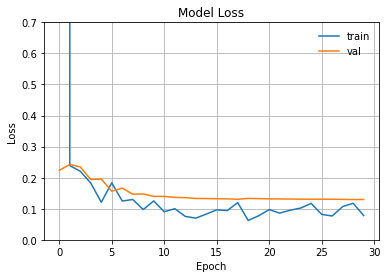

In [81]:
plt.plot(phase_loss_list['train'],label='train')
plt.plot(phase_loss_list['val'], label='val')
plt.legend(frameon=False)
plt.ylim(0, 0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title("Model Loss")
plt.show()

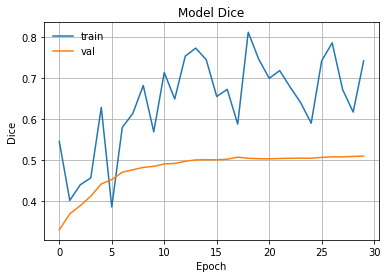

In [82]:
plt.plot(phase_dice_list['train'],label='train')
plt.plot(phase_dice_list['val'], label='val')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.grid()
plt.title("Model Dice")
plt.show()

In [83]:
torch.save(model_stud.state_dict(), "models/model_{}epoch_{}_fold{}.pth".format(num_epochs, "UNet11", "0"))

## Testing the student model

In [84]:
test_loader = make_loader(test_file_names, transform=val_transforms)

In [85]:
model_stud.load_state_dict(torch.load("models/model_30epoch_UNet11_fold0.pth", map_location="cuda:1"))

<All keys matched successfully>

0.53817236
6.167498e-06


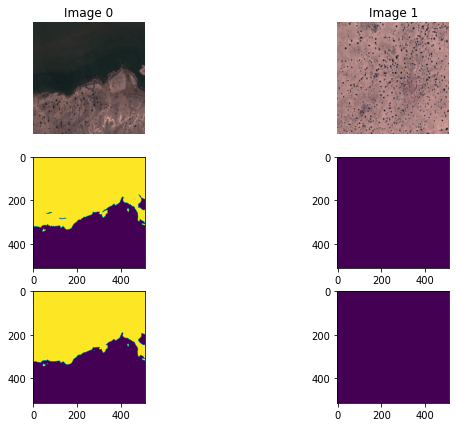

In [87]:
images, labels = next(iter(test_loader))

fig, axes = plt.subplots(figsize=(10,7), ncols=2, nrows=3)
for ii in range(2):
    ax = axes[0][ii]
    utils_plot.imshow(images[ii], mean_values, std_values, ax=ax, normalize=True, title="Image {}".format(ii))
    
    ax = axes[1][ii]
    label = labels[ii].squeeze().numpy()
    ax.imshow(label)
    
    ax = axes[2][ii]
    label = model_stud(images[ii].unsqueeze(0))
    label = torch.sigmoid(label.squeeze()).cpu().detach().numpy()
    print(label.mean())
    mask = label[:,:] > 0.5
    ax.imshow(mask)

In [90]:
dice_results = []

for data, target in tqdm(test_loader):
    data = data.to(device)
    target = target.to(device)
    
    with torch.no_grad():
        pred = model_stud(data)
        pred = torch.sigmoid(pred)
        dice = dice_coef(pred.cpu(), target.cpu())
        
        dice_results += [dice.data.cpu().numpy()]
    
print("Testing Statistics")
print("Test Dice = ", np.mean(dice_results))

100%|██████████| 46/46 [00:07<00:00,  6.40it/s]

Testing Statistics
Test Dice =  0.75697005
